In [1]:
import numpy as np
import matplotlib.pyplot as plt
input_path = "../data/vcrops_100_128.npz"

velf = np.load(input_path)
vel_a, vel_b = velf['wavespeedlist'][0], velf['wavespeedlist'][101]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = '14'

In [3]:
# set up models
import torch
import models.tiramisu as tiramisu
import models.unet as unet
import old_code.unet_Linear as unet2

#unet model setup
#unet_model = unet.UNet(wf=1, depth=3, scale_factor=2)
unet_model = unet2.UNet(depth=6, wf=1, acti_func='relu')
#unet_model = torch.nn.DataParallel(unet_model)
unet_model.load_state_dict(torch.load('../results/run_1/NLModule_w1_6layer_data[16].pt'))
unet_model.eval()
unet_model = unet_model.double()

#tiramisu model setup
#tir_model = tiramisu.FCDenseNet()
#tir_model = torch.nn.DataParallel(tir_model)
tir_model = unet2.UNet(depth=3, wf=1, acti_func='relu')
tir_model.load_state_dict(torch.load('../results/run_1/NLModule_w1_3layer_data[16].pt'))
tir_model.eval()
tir_model = tir_model.double()

netlist = [
    (r'unet 3lvl', unet_model),
    (r'tiramisu 55-55', tir_model)
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

unet 3lvl number of trainable parameters 2560008
tiramisu 55-55 number of trainable parameters 40008


In [4]:
# import all data generation files

import generate_data.WaveUtil as WaveUtil
import generate_data.wave2 as wave2
import generate_data.WavePostprocess4input as wp
import old_code.WavePostprocess4input as wp_old
from skimage.transform import resize

In [5]:
# parameter setup

Tf = 2.0
cT = 0.2
dx = 2.0/128.0
dt = dx / 20
ny, nx = 64, 64
m = 2
rt = 4
mt = round(Tf/cT)
t = np.linspace(0,Tf,mt)
ny, nx = 64, 64
x = np.arange(-1,1,dx)
y = np.arange(-1,1,dx)
xx,yy = np.meshgrid(x,y)

np.random.seed = 21
center = np.array([0.,0.])
# center_1 = np.array([-0.8,-0.8])
# u0_1 = np.exp(-250.0*(0.2*(xx-center_1[0])**2 + (yy-center_1[1])**2))*np.cos(8*np.pi*(yy-center_1[1]))
# center_2 = np.array([.8,.8])
# u0_2 = np.exp(-250.0*(0.2*(xx-center_2[0])**2 + (yy-center_2[1])**2))*np.cos(8*np.pi*(yy-center_2[1]))
# u0 = u0_1 + u0_2
u0 = np.exp(-250.0*(0.2*(xx-center[0])**2 + (yy-center[1])**2))*np.cos(8*np.pi*(yy-center[1]))
ut0 = np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])
vel = 1. + 0.0*yy - 0.5*(np.abs(yy+xx-0.)>0.4) + 0.*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1) #np.ones([np.size(xx,axis=1),np.size(yy,axis=0)]) #fig9 vel

# def four_layers(x, y):
#     res = x + np.pi / 3.1 * y
#     if res < -1:
#         return .2
#     elif res < 0:
#         return .6
#     elif res < 1:
#         return .8
#     else:
#         return 1
#
# # four layers velocity
# dim = 128
# v_x = np.linspace(-1, 1, num=dim)
# v_y = np.linspace(-1, 1, num=dim)
# z = np.array([four_layers(i, j) for j in v_y for i in v_x])
# Z = np.array(z).reshape(dim, dim)
# vel = Z

veltest = (
    #('waveguide',3. - 0.3*np.cos(np.pi*xx)),\
   #('inclusion',3.-0.5*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1)+0.5*(np.abs(xx-0.2)<0.2)*(np.abs(yy-0.3)<0.1) + 0.1*yy),\
   #('bp',gaussian_filter(resize(databp['V'][:,1300:3211],[128,128]),sigma=0)/1000),\
   #('marmousi',gaussian_filter(resize(datamarm['marm1smal'],[128,128]),sigma=0)/4),\
   ('refrac',vel),
    #('four layers', vel),
)

In [6]:
for velname, vel in veltest:

    #### Fine solution ####
    uf = np.zeros([xx.shape[0],xx.shape[1],mt])
    utf = np.zeros([xx.shape[0],xx.shape[1],mt])
    uf[:,:,0] = u0
    utf[:,:,0] = ut0
    for j in range(1,mt):
        uf[:,:,j],utf[:,:,j] = wave2.velocity_verlet_time_integrator(uf[:,:,j-1],utf[:,:,j-1],vel,dx,dt,cT)

    #### Coarse solution ####
    ucc = np.zeros([xx.shape[0],xx.shape[1],mt])
    utcc = np.zeros([xx.shape[0],xx.shape[1],mt])
    ucc[:,:,0] = u0
    utcc[:,:,0] = ut0
    uc = resize(ucc[:,:,0],[ny,nx],order=4)
    utc = resize(utcc[:,:,0],[ny,nx],order=4)
    velc = resize(vel,[ny,nx],order=4)
    
    for j in range(1,mt):
        uc, utc = wave2.velocity_verlet_time_integrator(uc,utc,velc,dx*m,dt*rt,cT)
        ucc[:,:,j] = resize(uc,[xx.shape[0],xx.shape[1]],order=4)
        utcc[:,:,j] = resize(utc,[xx.shape[0],xx.shape[1]],order=4)

    #### UNet solution ####
    unn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    utnn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    unn1[:,:,0] = u0
    utnn1[:,:,0] = ut0
    for j in range(1,mt):
        uc,utc = wave2.velocity_verlet_time_integrator(resize(unn1[:,:,j-1],[ny,nx],order=4),
                             resize(utnn1[:,:,j-1],[ny,nx],order=4),
                             resize(vel,[ny,nx],order=4),dx*m,dt*rt,cT)
        unn1[:,:,j],utnn1[:,:,j] = wp.ApplyNet2WaveSol(u0,ut0,uc,utc,vel,dx,unet_model)

    #### Tiramisu solution ####
    unn2 = np.zeros([xx.shape[0],xx.shape[1],mt])
    utnn2 = np.zeros([xx.shape[0],xx.shape[1],mt])
    unn2[:,:,0] = u0
    utnn2[:,:,0] = ut0
    for j in range(1,mt):
        uc,utc = wave2.velocity_verlet_time_integrator(resize(unn2[:,:,j-1],[ny,nx],order=4),
                             resize(utnn2[:,:,j-1],[ny,nx],order=4),
                             resize(vel,[ny,nx],order=4),dx*m,dt*rt,cT)

        unn2[:,:,j],utnn2[:,:,j] = wp.ApplyNet2WaveSol(u0,ut0,uc,utc,vel,dx,tir_model)

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


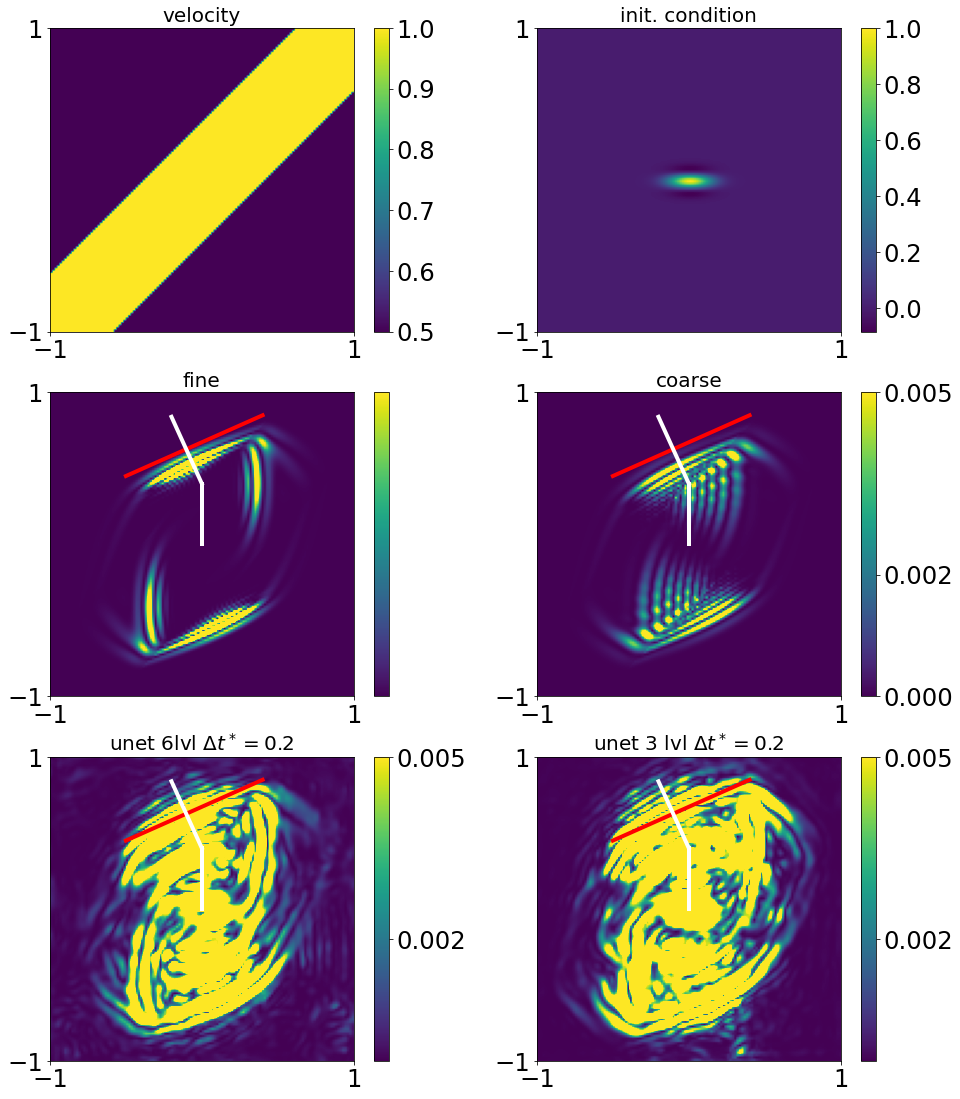

In [7]:
tj = 4
fig1 = plt.figure(figsize=(16,19))

ax1 = fig1.add_subplot(3,2,1)
pos1 = ax1.imshow(vel,extent=(-1,1,-1,1))
ax1.set_title('velocity', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos1)

ax2 = fig1.add_subplot(3,2,2)
pos2 = ax2.imshow(u0,extent=(-1,1,-1,1))
ax2.set_title('init. condition', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos2)

ax3 = fig1.add_subplot(3,2,3)
pos3 = ax3.imshow(WaveUtil.WaveEnergyField(uf[:,:,tj],utf[:,:,tj],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax3.set_title('fine', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.005])

ax4 = fig1.add_subplot(3,2,4)
pos4 = ax4.imshow(WaveUtil.WaveEnergyField(ucc[:,:,tj],utcc[:,:,tj],vel,dx)*dx*dx,vmax=.005,extent=(-1,1,-1,1))
ax4.set_title('coarse', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos4,ticks = [0,0.002,0.005])

ax5 = fig1.add_subplot(3,2,5)
pos5 = ax5.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj],utnn1[:,:,tj],vel,dx)*dx*dx,vmax=.005,extent=(-1,1,-1,1))
ax5.set_title(r'unet 6lvl $\Delta t^*=0.2$', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos5,ticks = [0,0.002,0.005])

ax6 = fig1.add_subplot(3,2,6)
pos6 = ax6.imshow(WaveUtil.WaveEnergyField(unn2[:,:,tj],utnn2[:,:,tj],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax6.set_title(r'unet 3 lvl $\Delta t^*=0.2$', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos6, ticks = [0,0.002,0.005])

In [11]:
# compare wave energy norm errors:

from sklearn.metrics import mean_squared_error

for it in range(8):
    wf = WaveUtil.WaveEnergyField(uf[:,:,it], utf[:,:,it], vel, dx)*dx*dx
    w1 = WaveUtil.WaveEnergyField(unn1[:,:,it], utnn1[:,:,it], vel, dx)*dx*dx
    w2 = WaveUtil.WaveEnergyField(unn2[:,:,it], utnn2[:,:,it], vel, dx)*dx*dx

    mse1 = mean_squared_error(wf, w1)
    mse2 = mean_squared_error(wf, w2)

    print(it, mse1, mse2)

0 0.0 0.0
1 7.786058538123004e-06 6.6285017542773274e-06
2 3.866357356403766e-05 2.5522299288643253e-05
3 6.834154153544615e-05 5.9571916854026067e-05
4 0.0002624700945686578 0.0001887119267053284
5 0.001360754044801662 0.0007663344650958075
6 0.009715833934909362 0.004223810589828859
7 0.06476018073098407 0.027677035554959657


In [ ]:
tj = 2
r = (uf[:,:,tj:tj+1] - np.min(uf[:,:,tj:tj+1]))
r = r/np.max(r)
b = (utf[:,:,tj:tj+1] - np.min(utf[:,:,tj:tj+1]))
b = b/np.max(b)
g = np.zeros_like(r)#(vel[:,:,np.newaxis] - np.min(vel[:,:]))
g = g/np.max(g)

plt.figure()
plt.imshow(np.concatenate((r,b,g),axis=2))

In [ ]:
tj = 2
wx,wy,wtc = WaveUtil.WaveEnergyComponentField(unn4[:,:,tj:tj+1],utnn4[:,:,tj:tj+1],vel,dx)

r = (wx - np.min(wx))
r = r/np.max(r)
b = (wy - np.min(wy))
b = b/np.max(b)
g = (wtc - np.min(wtc))
g = g/np.max(g)

plt.figure()
plt.imshow(np.concatenate((r,b,g),axis=2))

In [ ]:
tj = 4
u0e = ((WaveUtil.WaveEnergyField(u0,ut0,vel,dx)*dx*dx))
ufe = ((WaveUtil.WaveEnergyField(uf[:,:,tj],utf[:,:,tj],vel,dx)*dx*dx))
uce = ((WaveUtil.WaveEnergyField(unn4[:,:,tj],utnn4[:,:,tj],vel,dx)*dx*dx))
u1e = (WaveUtil.WaveEnergyField(unn1[:,:,tj],utnn1[:,:,tj],vel,dx)*dx*dx)
u2e = (WaveUtil.WaveEnergyField(unn2[:,:,tj],utnn2[:,:,tj],vel,dx)*dx*dx)

fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(1,2,1)
pos1 = ax1.imshow(u0e,vmin=-0.001,vmax=0.001)

plt.colorbar(pos1)
ax2 = fig1.add_subplot(1,2,2)
ax2.imshow(u2e,vmin=-0.001,vmax=0.001)

plt.colorbar(pos1)
#plt.savefig('./figures/abserror_serialNN.eps')

In [ ]:
xr = np.linspace(-1,1,128)
lw=2.5
plt.plot(xr,ufe[:,63].T,label='fine',linewidth=lw)
plt.plot(xr,uce[:,63],'--',label='coarse',linewidth=lw)
plt.plot(xr,u1e[:,63],'-.',label=r'lin. 3-level',linewidth=lw)
plt.plot(xr,u2e[:,63],':',label=r'lin. 6-level',linewidth=lw)
plt.xlabel('x')
plt.xlim([0,1])
plt.ylim([0,0.025])
plt.legend()
plt.title(r'$T=0.8, \Delta t^*=0.2$')
plt.ylabel('energy')
#plt.savefig('./refraction_red_energyfieldT08.eps',bbox_inches = "tight")

In [ ]:
xr = np.linspace(-1,1,128)
#plt.plot(xr,u0e[63,:],label=r'$t=0$')
plt.plot(xr,ufe[np.arange(0,128),np.arange(0,128)].T,label='fine',linewidth=lw)
plt.plot(xr,uce[np.arange(0,128),np.arange(0,128)],'--',label='coarse',linewidth=lw)
plt.plot(xr,u1e[np.arange(0,128),np.arange(0,128)],'-.',label=r'lin. 3-level',linewidth=lw)
plt.plot(xr,u2e[np.arange(0,128),np.arange(0,128)],':',label=r'lin. 6-level',linewidth=lw)
plt.xlabel('x')
plt.xlim([0,1])
plt.ylim([0,0.0025])
plt.legend()
plt.title(r'$T=0.8, \Delta t^*=0.2$')
plt.ylabel('energy')
plt.savefig('./refraction_green_energyfieldT08.eps',bbox_inches = "tight")

In [ ]:
import parareal2
maxiter = 4
unn1,utnn1 = parareal2.parareal2_NNpostprocess(u0,ut0,vel,dx,dt,cT=0.2,m=2,tm=8,T=1.0,pimax=maxiter,\
                                               net=net1,continue_train=False)

In [ ]:
unn1.shape

In [ ]:
tj = 4
fig1 = plt.figure(figsize=(16,13))
ax1 = fig1.add_subplot(2,2,1)
pos1 = ax1.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj,0],utnn1[:,:,tj,0],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax1.set_title(r'$k=1$')
plt.xticks([-1,1])
plt.yticks([-1,1])
ax1.set_ylabel('y')
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.004])

ax2 = fig1.add_subplot(2,2,2)
ax2.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj,1],utnn1[:,:,tj,1],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax2.set_title(r'$k=2$')
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.004])

ax3 = fig1.add_subplot(2,2,3)
ax3.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj,2],utnn1[:,:,tj,2],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax3.set_title(r'$k=3$')
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.004])

ax4 = fig1.add_subplot(2,2,4)
ax4.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj,3],utnn1[:,:,tj,3],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax4.set_title(r'$k=4$')
ax4.set_xlabel('x')
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.004])

plt.savefig('./beamrefraction_uenergy_parareal3lvl.eps')

In [ ]:
t = np.linspace(0,Tf,mt)
fe = []
ce = []
nn1e = []
nn2e = []
nn3e = []
nn4e = []
for i in range(mt):
    fe.append(np.sum(WaveUtil.WaveEnergyField(uf[:,:,i],utf[:,:,i],vel,dx)*dx*dx))
    ce.append(np.sum(WaveUtil.WaveEnergyField(ucc[:,:,i],utcc[:,:,i],vel,dx)*dx*dx))
    nn1e.append(np.sum(WaveUtil.WaveEnergyField(unn1[:,:,i],utnn1[:,:,i],vel,dx)*dx*dx))
    nn2e.append(np.sum(WaveUtil.WaveEnergyField(unn2[:,:,i],utnn2[:,:,i],vel,dx)*dx*dx))
    nn3e.append(np.sum(WaveUtil.WaveEnergyField(unn3[:,:,i],utnn3[:,:,i],vel,dx)*dx*dx))
    nn4e.append(np.sum(WaveUtil.WaveEnergyField(unn4[:,:,i],utnn4[:,:,i],vel,dx)*dx*dx))
    ## Check wave energy computation here!!!!

plt.plot(t,fe,label='fine')
plt.plot(t,ce,label='coarse')
plt.plot(t,nn1e,label=netlist[0][0])
plt.plot(t,nn2e,label=netlist[1][0])
plt.plot(t,nn3e,label=netlist[2][0])
plt.plot(t,nn4e,label=netlist[3][0])
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('t')
plt.ylabel('wave energy')
#plt.savefig('./refraction_totalenergyT08.eps',bbox_inches = "tight")

In [ ]:
print(reftime/(mt-1)*0.5)
print(nn1time/(mt-1)*0.5)
print(nn2time/(mt-1)*0.5)
print(nn3time/(mt-1)*0.5)
print(coartime/(mt-1)*0.5)

|          |conv counts |Timing |
|----------|------------|-------|
|Fine solver $\Delta t_{com}=0.1$|256|0.054|
|Linear 4-level init. channels=4 | 244 | 0.041|
|ReLU 4-level init. channels=16 | 3824 |0.193|
|Linear 7-level init. channels=4 |460 | 0.043|
|ReLU 7-level init. channels=4 | 460 | 0.044|
|ComNet 7-level init. channels=4| 460x3 | 0.234|

In [ ]:
nntime/(2*(mt-1))

### Velocity model gallery

In [ ]:
Tf = 1.5
cT = 0.2
dx = 2.0/128.0
dt = dx/20
x = np.arange(-1,1,dx)
y = np.arange(-2,2,dx)
xx,yy = np.meshgrid(x,y)
np.random.seed = 21
center = np.array([0.3,-0.4])

u0 = np.exp(-250.0*(0.2*(xx-center[0])**2 + (yy-center[1])**2))*np.cos(8*np.pi*(yy-center[1]))
ut0 = np.zeros([xx.shape[0],xx.shape[1]])

veltest = (('L2-ball',1 - 0.3*((xx)**2+(yy-0.2)**2 <0.3**2)),\
           ('L1-ball',1 - 0.3*(abs(xx)+abs(yy-0.2) <0.3)),\
           ('thin slab',1 - 0.3*(abs(xx)<0.3)*(abs(yy-0.)<0.05)),\
           ('3 slabs',1 - 0.3*(abs(xx)<0.3)*(abs(yy-0.)<0.05) - 0.3*(abs(xx)<0.3)*(abs(yy-0.2)<0.05)\
                           - 0.3*(abs(xx)<0.3)*(abs(yy-0.4)<0.05)),\
          )

In [ ]:
fig1 = plt.figure(figsize=(10,10))
i = 1

for vname,vel in veltest:
    ax1 = fig1.add_subplot(2,2,i)
    pos1 = ax1.imshow(vel,extent=(-1,1,-1,1))
    plt.xticks([-1,1])
    plt.yticks([-1,1])
    plt.title(vname)
    plt.annotate('X',(0.3,0.4))
    plt.colorbar(pos1)
    i += 1

#plt.savefig('./figures/refraction_vel.eps',bbox_inches = "tight")

In [ ]:
plt.imshow(u0,extent=(-1,1,-2,2))
plt.colorbar()
plt.savefig('./gallery_init.png',bbox_inches = "tight")

In [ ]:
m = 2
ny = round(yy.shape[0]/m)
nx = round(xx.shape[1]/m)
mt = round(Tf/cT)

t = np.linspace(0,Tf,mt)

fig1 = plt.figure(figsize=(16,20))

subplotframe = 1

for velname,vel in veltest:
    titl = True
    
    #### Reference solution ####
    uf = np.zeros([xx.shape[0],xx.shape[1],mt])
    utf = np.zeros([xx.shape[0],xx.shape[1],mt])
    uf[:,:,0] = u0
    utf[:,:,0] = ut0
    ue = uf[:,:,0]
    ute = utf[:,:,0]
    for j in range(1,mt):   
        uf[:,:,j],utf[:,:,j] = wave2.wave2(uf[:,:,j-1],utf[:,:,j-1],vel,dx,dt,cT)
        
    #### Coarse solution ####
    ucc = np.zeros([xx.shape[0],xx.shape[1],mt])
    utcc = np.zeros([xx.shape[0],xx.shape[1],mt])
    ucc[:,:,0] = u0
    utcc[:,:,0] = ut0
    uc = resize(ucc[:,:,0],[ny,nx],order=4)
    utc = resize(utcc[:,:,0],[ny,nx],order=4)
    velc = resize(vel,[ny,nx],order=4)
    
    for j in range(1,mt):
        uc,utc = wave2.wave2(uc,utc,velc,dx*m,dt*8,cT)
        #uc,utc = wave2.wave2(resize(ucc[:,:,j-1],[ny,nx],order=4),\
        #                     resize(utcc[:,:,j-1],[ny,nx],order=4),resize(vel,[ny,nx],order=4),dx*m,dt*8,cT)
        ucc[:,:,j] = resize(uc,[xx.shape[0],xx.shape[1]],order=4)
        utcc[:,:,j] = resize(utc,[xx.shape[0],xx.shape[1]],order=4)
    
    #### Net 1 solution ####
    unn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    utnn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    unn1[:,:,0] = u0
    utnn1[:,:,0] = ut0

    for j in range(1,mt):
        uc,utc = wave2.wave2(resize(unn1[:,:,j-1],[ny,nx],order=4),\
                             resize(utnn1[:,:,j-1],[ny,nx],order=4),resize(vel,[ny,nx],order=4),dx*m,dt*8,cT)
        unn1[:,:,j],utnn1[:,:,j] = wp.ApplyJNet2WaveSol(uc,utc,vel,dx,net1)
    
    
    energyuf = np.sum(WaveUtil.WaveEnergyField(uf[:,:,-1],utf[:,:,-1],vel,dx))
    ccerror = WaveUtil.WaveEnergyField(uf[:,:,-1]-ucc[:,:,-1],utf[:,:,-1]-utcc[:,:,-1],vel,dx)/energyuf
    nn1error = WaveUtil.WaveEnergyField(uf[:,:,-1]-unn1[:,:,-1],utf[:,:,-1]-utnn1[:,:,-1],vel,dx)/energyuf
        
    ax1 = fig1.add_subplot(4,3,subplotframe)
    pos1 = ax1.imshow(uf[:,:,-1],extent=(-1,1,-2,2))
    plt.title('fine soln')
    plt.ylim([-1,1])
    plt.colorbar(pos1)
    plt.axis('off')
    
    ax2 = fig1.add_subplot(4,3,subplotframe+1)
    pos2 = ax2.imshow(ucc[:,:,-1],extent=(-1,1,-2,2))
    plt.axis('off')
    plt.title('coarse soln')
    plt.ylim([-1,1])
    plt.colorbar(pos1)
    
    ax3 = fig1.add_subplot(4,3,subplotframe+2)
    pos3 = ax3.imshow(unn1[:,:,-1],extent=(-1,1,-2,2))
    plt.axis('off')
    plt.title('Jnet soln')
    plt.ylim([-1,1])
    plt.colorbar(pos1)
    
    ####
    subplotframe += 3
    
#plt.savefig('./gallery_jnett15_soln.png',bbox_inches = "tight")

In [ ]:
fig1 = plt.figure(figsize=(16,20))

subplotframe = 1

for velname,vel in veltest:
    titl = True
    
    #### Reference solution ####
    uf = np.zeros([xx.shape[0],xx.shape[1],mt])
    utf = np.zeros([xx.shape[0],xx.shape[1],mt])
    uf[:,:,0] = u0
    utf[:,:,0] = ut0
    ue = uf[:,:,0]
    ute = utf[:,:,0]
    for j in range(1,mt):   
        uf[:,:,j],utf[:,:,j] = wave2.wave2(uf[:,:,j-1],utf[:,:,j-1],vel,dx,dt,cT)
        
    #### Coarse solution ####
    ucc = np.zeros([xx.shape[0],xx.shape[1],mt])
    utcc = np.zeros([xx.shape[0],xx.shape[1],mt])
    ucc[:,:,0] = u0
    utcc[:,:,0] = ut0
    uc = resize(ucc[:,:,0],[ny,nx],order=4)
    utc = resize(utcc[:,:,0],[ny,nx],order=4)
    velc = resize(vel,[ny,nx],order=4)
    
    for j in range(1,mt):
        uc,utc = wave2.wave2(uc,utc,velc,dx*m,dt*8,cT)
        #uc,utc = wave2.wave2(resize(ucc[:,:,j-1],[ny,nx],order=4),\
        #                     resize(utcc[:,:,j-1],[ny,nx],order=4),resize(vel,[ny,nx],order=4),dx*m,dt*8,cT)
        ucc[:,:,j] = resize(uc,[xx.shape[0],xx.shape[1]],order=4)
        utcc[:,:,j] = resize(utc,[xx.shape[0],xx.shape[1]],order=4)
    
    #### Net 1 solution ####
    unn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    utnn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    unn1[:,:,0] = u0
    utnn1[:,:,0] = ut0

    for j in range(1,mt):
        uc,utc = wave2.wave2(resize(unn1[:,:,j-1],[ny,nx],order=4),\
                             resize(utnn1[:,:,j-1],[ny,nx],order=4),resize(vel,[ny,nx],order=4),dx*m,dt*8,cT)
        unn1[:,:,j],utnn1[:,:,j] = wp.ApplyJNet2WaveSol(uc,utc,vel,dx,net1)
    
    #### Error measurement ####
    ccerror = np.zeros([xx.shape[0],xx.shape[1]])
    nn1error = np.zeros([xx.shape[0],xx.shape[1]])
    
    
    energyuf = np.sum(WaveUtil.WaveEnergyField(uf[:,:,-1],utf[:,:,-1],vel,dx))
    ccerror = WaveUtil.WaveEnergyField(uf[:,:,-1]-ucc[:,:,-1],utf[:,:,-1]-utcc[:,:,-1],vel,dx)/energyuf
    nn1error = WaveUtil.WaveEnergyField(uf[:,:,-1]-unn1[:,:,-1],utf[:,:,-1]-utnn1[:,:,-1],vel,dx)/energyuf
        
    ax1 = fig1.add_subplot(4,3,subplotframe)
    pos1 = ax1.imshow(vel,extent=(-1,1,-2,2))
    plt.title(velname)
    plt.annotate('X',(0.3,0.4))
    plt.ylim([-1,1])
    plt.colorbar(pos1)
    plt.axis('off')
    
    ax2 = fig1.add_subplot(4,3,subplotframe+1)
    pos2 = ax2.imshow(ccerror,extent=(-1,1,-2,2),vmax=0.002)
    plt.axis('off')
    plt.title('coarse error')
    plt.ylim([-1,1])
    plt.colorbar(pos2,ticks=[1e-3,2e-3])
    
    ax3 = fig1.add_subplot(4,3,subplotframe+2)
    pos3 = ax3.imshow(nn1error,extent=(-1,1,-2,2),vmax=0.002)
    plt.axis('off')
    plt.title('Jnet error')
    plt.ylim([-1,1])
    plt.colorbar(pos2,ticks=[1e-3,2e-3])
    
    ####
    subplotframe += 3
    
#plt.savefig('./gallery_error_jnett15.svg',bbox_inches = "tight")